# GMD Normalization and Correlation  - DESC Commisioning 30th April '19

In [1]:
%matplotlib inline

import h5py;
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import kde

In [2]:
plt.rcParams.update({'font.size': 20})

DAQ run with delay scan

In [3]:
run_number = 28496

data_dir = '/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/'
hdf_filename = 'FLASH1_USER1-run'+str(run_number)+'.h5'

gmd_ave_bda_addr = '/FL1/Photon Diagnostic/GMD/Average energy/energy BDA (raw)'
gmd_ave_tunnel_addr = '/FL1/Photon Diagnostic/GMD/Average energy/energy tunnel (raw)'
gmd_pulse_res_bda_addr = '/FL1/Photon Diagnostic/GMD/Pulse resolved energy/energy BDA (raw)'
gmd_pulse_res_tunnel_addr = '/FL1/Photon Diagnostic/GMD/Pulse resolved energy/energy tunnel (raw)'

print(data_dir+hdf_filename)

/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/FLASH1_USER1-run28496.h5


### Read GMD from h5 file 

In [4]:
hdf_file = h5py.File(data_dir+hdf_filename,'r')

gmd_ave_bda = hdf_file[gmd_ave_bda_addr][()]
gmd_ave_tunnel = hdf_file[gmd_ave_tunnel_addr][()]
gmd_pulse_res_bda = hdf_file[gmd_pulse_res_bda_addr][()]
gmd_pulse_res_tunnel = hdf_file[gmd_pulse_res_tunnel_addr][()]

### Plot averaged GMD versus file index 

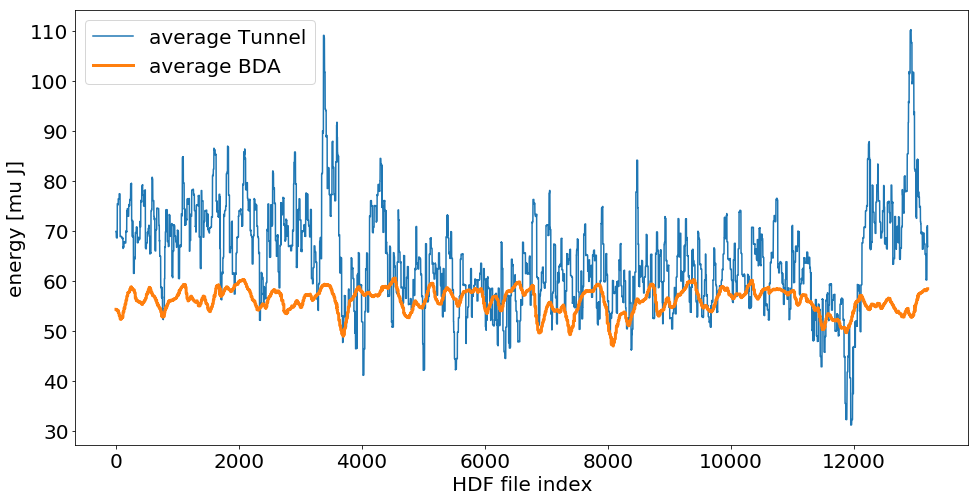

In [5]:
plt.figure(figsize=(16,8))
plt.plot(gmd_ave_tunnel, label = 'average Tunnel')
plt.plot(gmd_ave_bda, label = 'average BDA', lw = 3)
plt.xlabel('HDF file index')
plt.ylabel('energy [mu J]')
plt.legend()
plt.show()

### Plot averaged GMD versus file index 

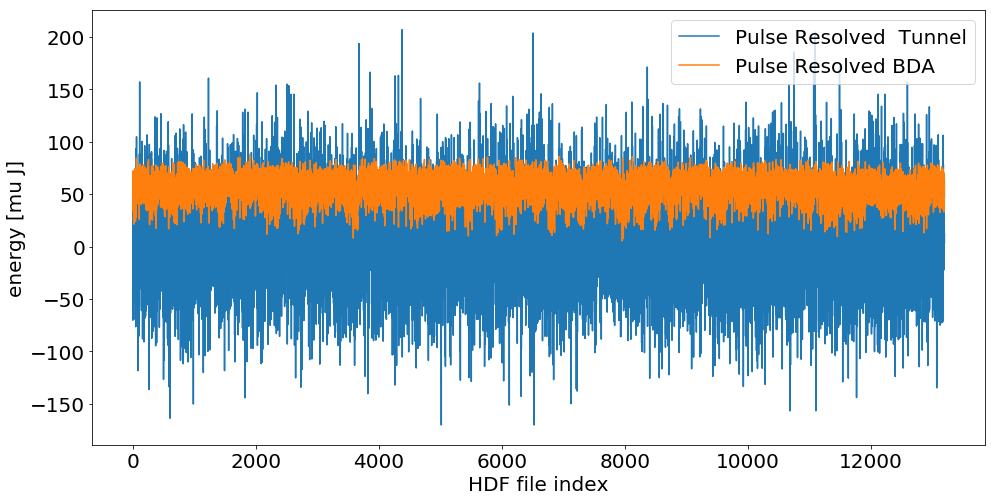

In [6]:
plt.figure(figsize=(16,8))
plt.plot(gmd_pulse_res_tunnel, label = 'Pulse Resolved  Tunnel')
plt.plot(gmd_pulse_res_bda, label = 'Pulse Resolved BDA')
plt.xlabel('HDF file index')
plt.ylabel('energy [mu J]')
plt.legend()
plt.show()

### <span style="color:red">negative values for pulse resolved GMD values in tunnel</span>

## check pulse resolved tunnel values for smaller than Zero

In [7]:
print('total number of values: ',len(gmd_pulse_res_tunnel))
print('number of values smaller than Zero: ',len(gmd_pulse_res_tunnel[gmd_pulse_res_tunnel<0]))
print('number of NaNs: ', np.sum(np.isnan(gmd_pulse_res_tunnel)))

total number of values:  13200
number of values smaller than Zero:  5714
number of NaNs:  5


/software/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


## distribution of pulse resolved GMD values

/software/anaconda3/5.2/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/software/anaconda3/5.2/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


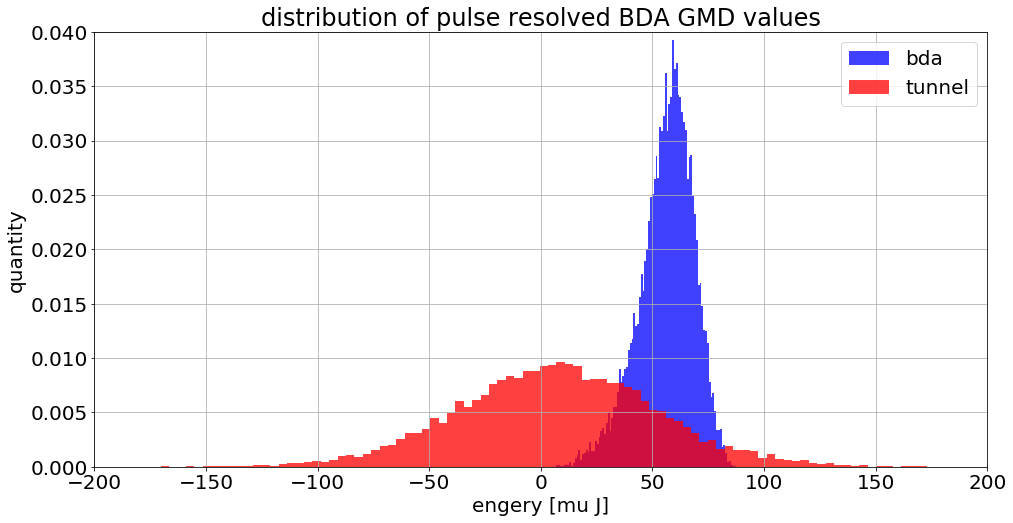

In [8]:
plt.figure(figsize=(16,8))
plt.hist(gmd_pulse_res_bda,100, density= True, facecolor = 'b', alpha=0.75, label = 'bda')
plt.hist(gmd_pulse_res_tunnel,100, density= True, facecolor = 'r', alpha=0.75, label = 'tunnel')
plt.xlabel('engery [mu J]')
plt.ylabel('quantity')
plt.title('distribution of pulse resolved BDA GMD values')
plt.axis([-200, 200, 0, 0.04])
plt.legend()
plt.grid(True)

### using BDA GMD as the tunnel GMD is mainly Noise (low gas pressure ?) !
RuntimeWarning results from NaNs in pulse resolved GMD dataset

# GMD Correlations

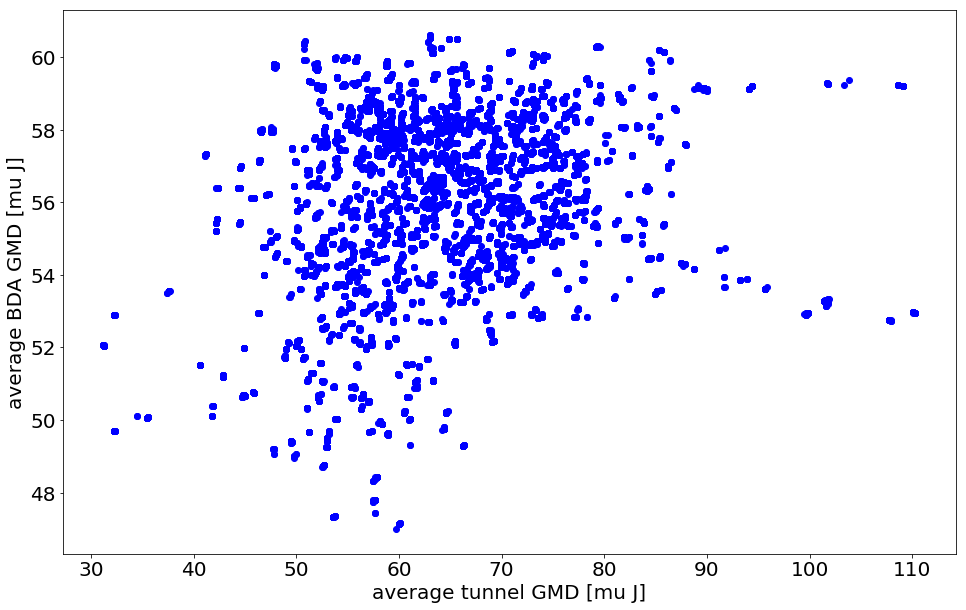

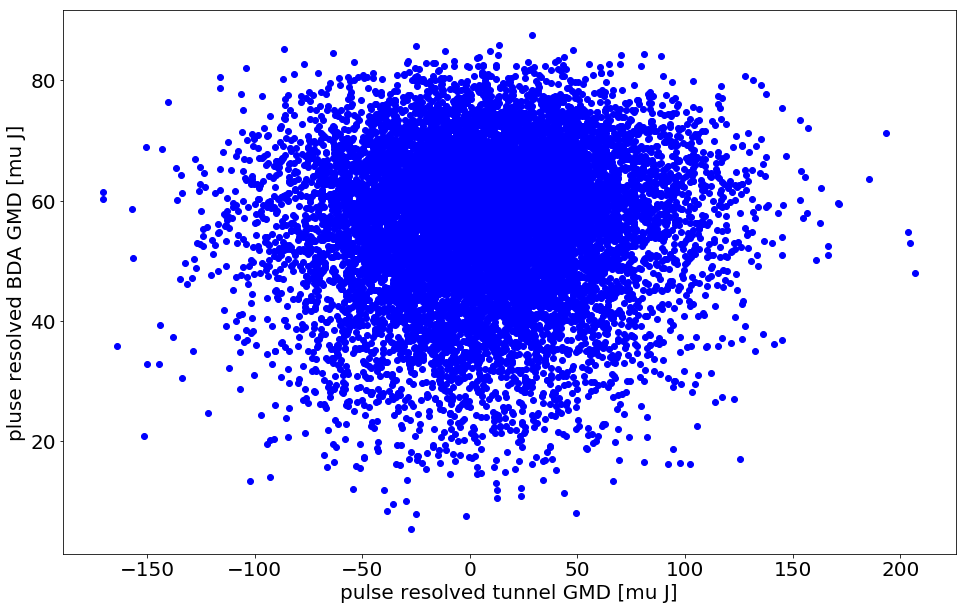

In [9]:
plt.figure(figsize=(16,10))
plt.plot(gmd_ave_tunnel, gmd_ave_bda, 'bo')
plt.xlabel('average tunnel GMD [mu J]')
plt.ylabel('average BDA GMD [mu J]');

plt.figure(figsize=(16,10))
plt.plot(gmd_pulse_res_tunnel, gmd_pulse_res_bda, 'bo')
plt.xlabel('pulse resolved tunnel GMD [mu J]')
plt.ylabel('pluse resolved BDA GMD [mu J]')
plt.show()

In [10]:
def calc_density_of_correlation(array_x, array_y, nbins = 300):    
    x = np.asarray([array_x[index] for index in range(len(array_x)) if array_x[index] == array_x[index] and array_y[index] == array_y[index]])
    y = np.asarray([array_y[index] for index in range(len(array_y)) if array_x[index] == array_x[index] and array_y[index] == array_y[index]])
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return xi, yi, zi.reshape(xi.shape) 

def plot_density_of_correlation(array_x, array_y, nbins = 300):
    x, y, z = calc_density_of_correlation(array_x, array_y, nbins = 300)
    plt.pcolormesh(x,y,z)

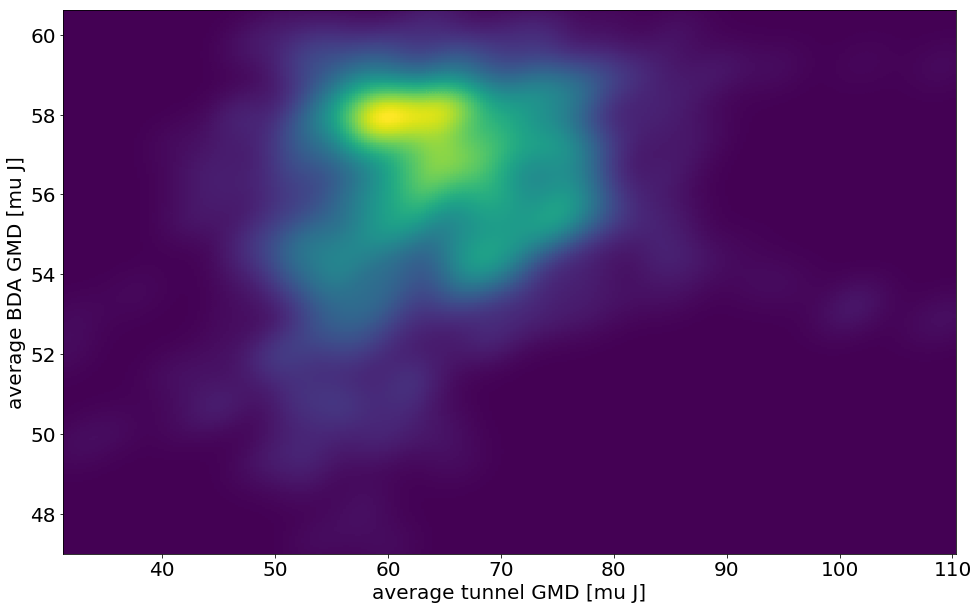

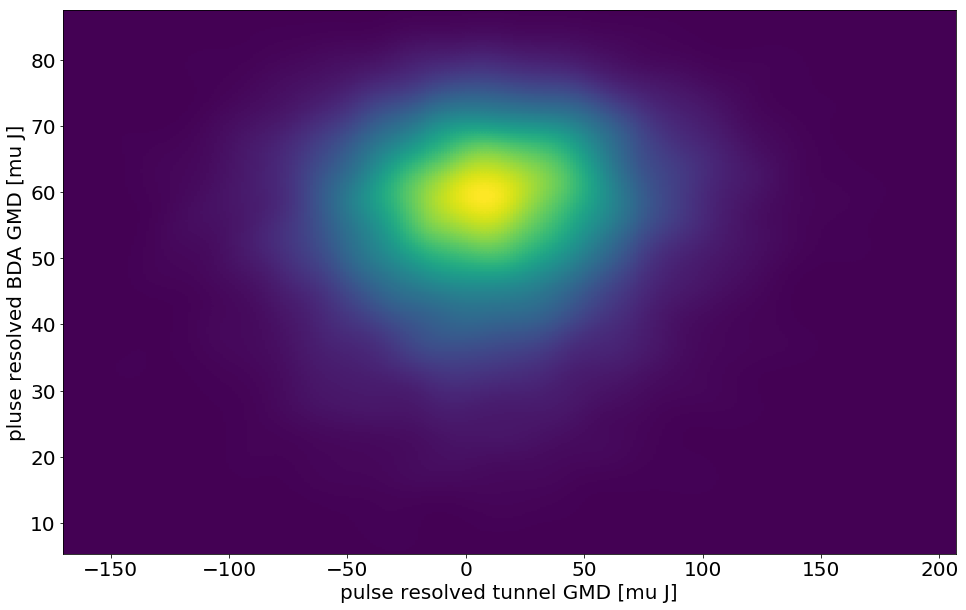

In [11]:
plt.figure(figsize=(16,10))
plot_density_of_correlation(gmd_ave_tunnel.flatten(), gmd_ave_bda.flatten())
plt.xlabel('average tunnel GMD [mu J]')
plt.ylabel('average BDA GMD [mu J]')

plt.figure(figsize=(16,10))
plot_density_of_correlation(gmd_pulse_res_tunnel.flatten(), gmd_pulse_res_bda.flatten())
plt.xlabel('pulse resolved tunnel GMD [mu J]')
plt.ylabel('pluse resolved BDA GMD [mu J]')
plt.show()

# Calculate GAIN to normalize pulse resolved GMD values

https://www-users.cs.york.ac.uk/~fisher/cgi-bin/mkfscript

* Bessel filter 
* corner 1 freq: 0.010 Hz - 0.014 Hz 
* 1 order 
* sample rate: 10

```

std::array<float, size> in{};
std::array<float, size> out{};

in = ... // fill

const double a0 = 0.00500145;
const double a1 = 0.00500145;
const double b1 = 0.989997;

// a0 := a1 := 'fischer' 1/GAIN
// b1 := 1.0 - a0 - a1

for (int i = 1; i < in.size(); ++i) {
  out[i] = a0 * in[i] + a1 * in[i-1] + b1 * out[i-1];
  
```

#### averaged GMD = Ion Signal
#### pulse resolved GMD = Electron Signal

### define filter and filter coefficient

In [12]:
def filter_electron_signal(input_array):
    a0 = 0.00500145
    a1 = a0
    b1 = 1 - a0 - a1 
    output_list = [input_array[0]]
    for i in range(1,len(input_array)):
        output_list.append(a0 * input_array[i]+a1*input_array[i-1]+b1*output_list[i-1])
    return np.asarray(output_list)

## hardware-like filter on pulse resolved GMD values

In [13]:
filtered_electron_gmd_bda = filter_electron_signal(np.nan_to_num(gmd_pulse_res_bda))

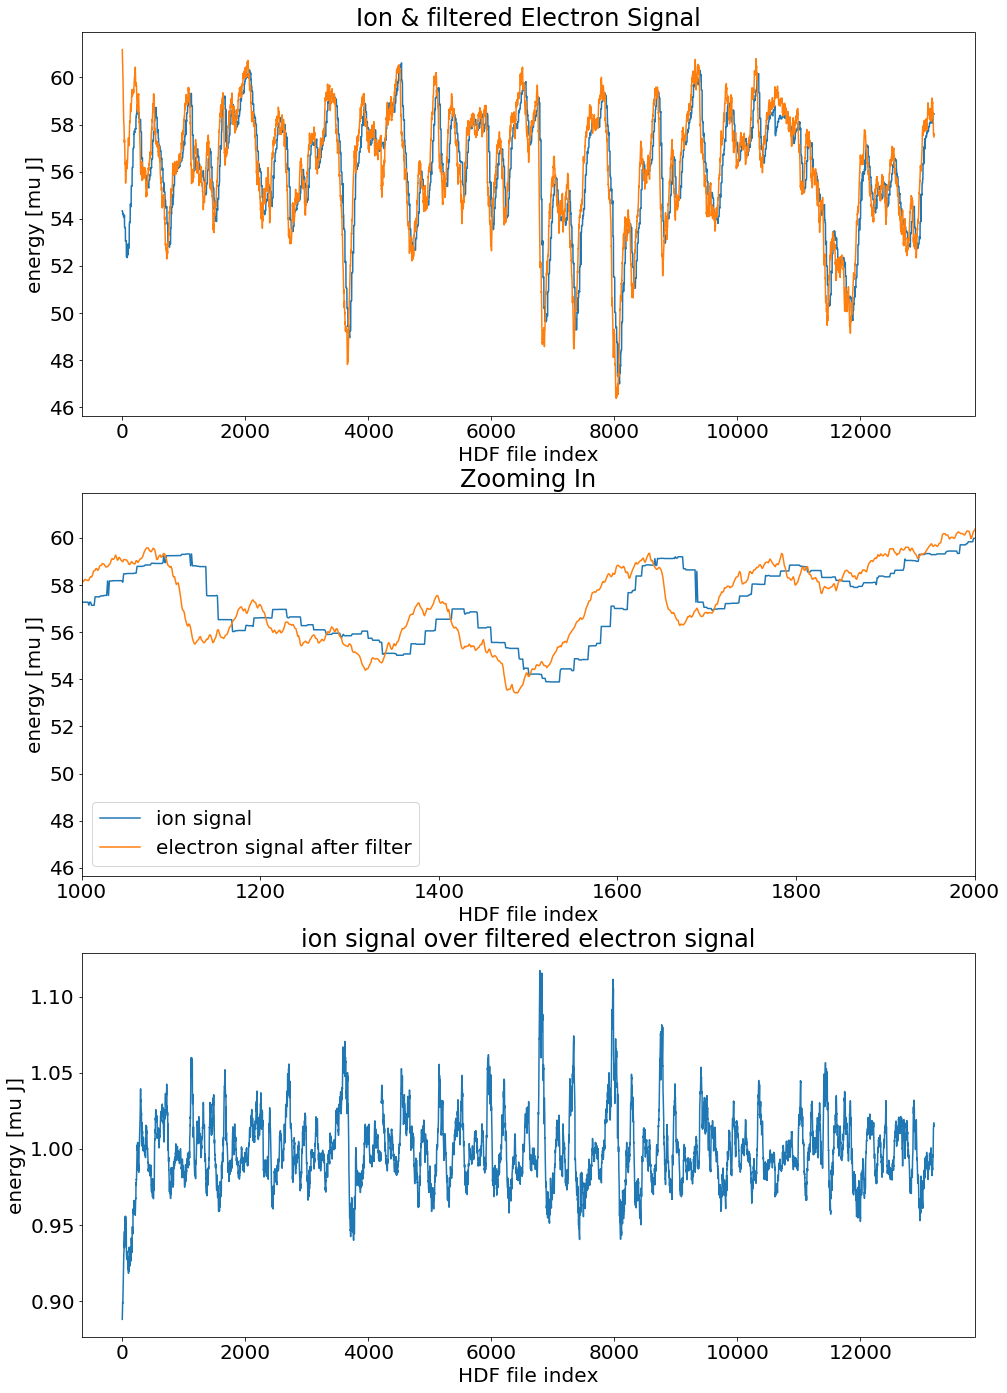

In [14]:
plt.figure(figsize=(16,24))

plt.subplot(311)
plt.plot(gmd_ave_bda, label = 'ion signal')
plt.plot(filtered_electron_gmd_bda,  label = 'electron signal after filter')
plt.xlabel('HDF file index')
plt.ylabel('energy [mu J]')
plt.title('Ion & filtered Electron Signal')

plt.subplot(312)
plt.plot(gmd_ave_bda, label = 'ion signal')
plt.plot(filtered_electron_gmd_bda,  label = 'electron signal after filter')
plt.xlabel('HDF file index')
plt.ylabel('energy [mu J]')
plt.legend()
plt.xlim(1000,2000)
plt.title('Zooming In')

plt.subplot(313)
plt.plot(gmd_ave_bda / filtered_electron_gmd_bda)
plt.xlabel('HDF file index')
plt.ylabel('energy [mu J]')
plt.title('ion signal over filtered electron signal')

plt.show()

## Shift Ion Signal to compensate for Keyleigh delay time 

Max:  1.0406642707449385 |  Min:  0.9686382025098333


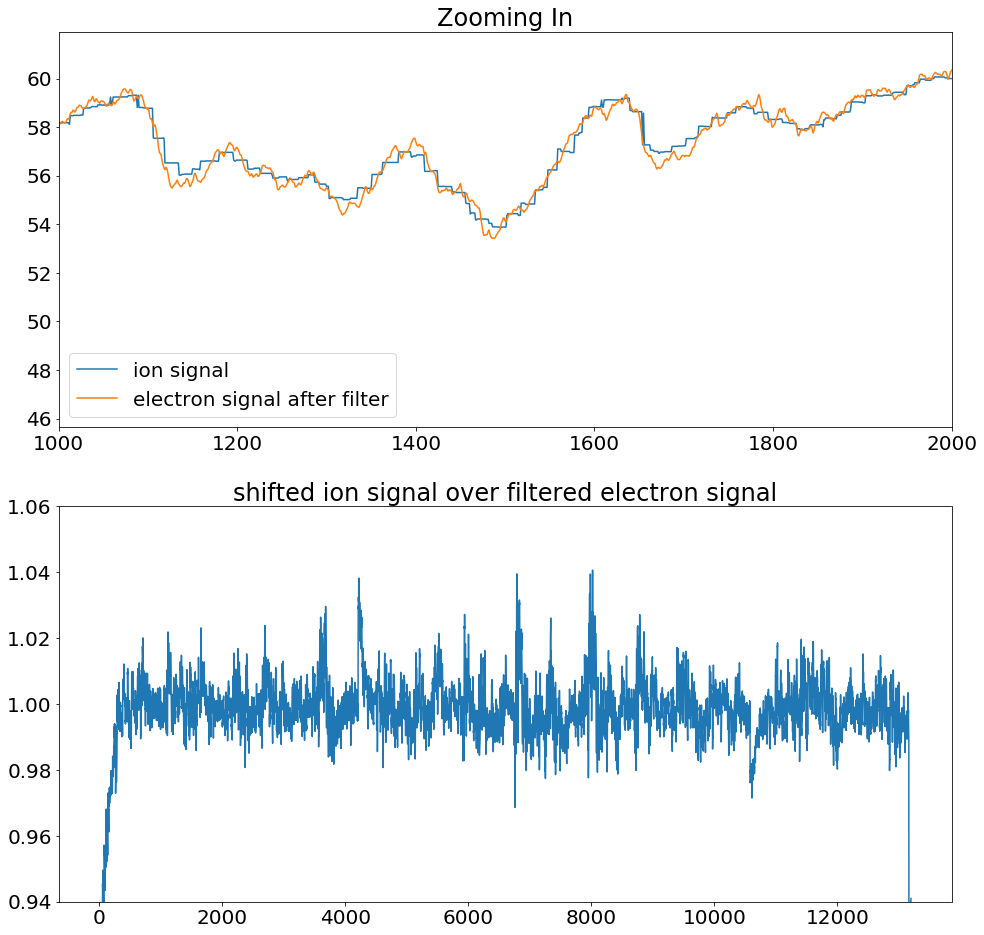

In [15]:
time_shift = -34
shifted_gmd_ave_bda =np.roll(gmd_ave_bda, time_shift)
ratio_ion_filtered_electron_signal = shifted_gmd_ave_bda / filtered_electron_gmd_bda

plt.figure(figsize=(16,16))

plt.subplot(211)
plt.plot(shifted_gmd_ave_bda, label = 'ion signal')
plt.plot(filtered_electron_gmd_bda,  label = 'electron signal after filter')
plt.legend()
plt.xlim(1000,2000)
plt.title('Zooming In')

plt.subplot(212)
plt.plot(ratio_ion_filtered_electron_signal)
plt.ylim(0.94,1.06)
plt.title('shifted ion signal over filtered electron signal')

print('Max: ',np.nanmax(ratio_ion_filtered_electron_signal[1000:12500]),'|  Min: ',np.nanmin(ratio_ion_filtered_electron_signal[1000:12500]))

## Check for Improvment via Correlation

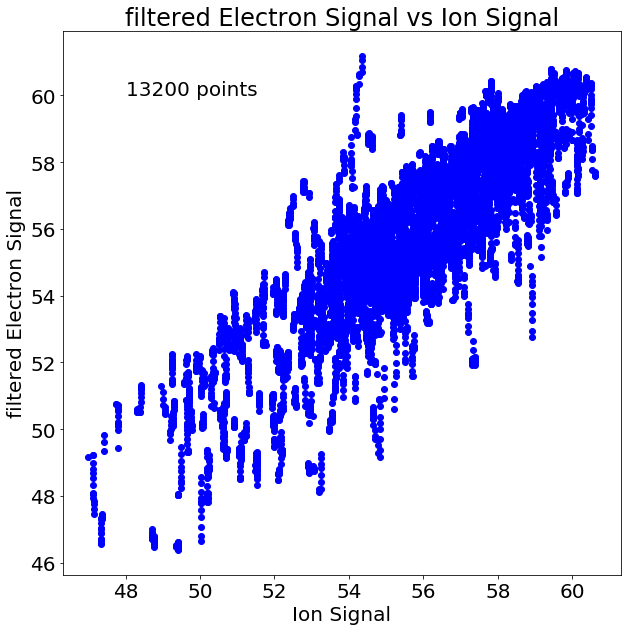

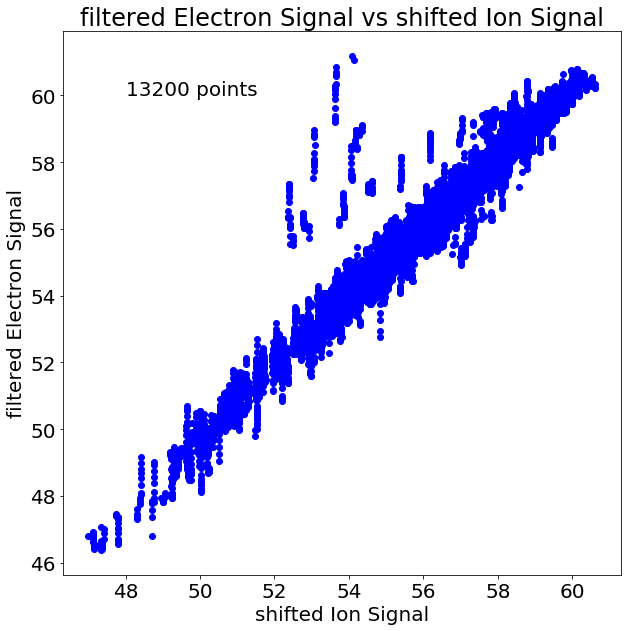

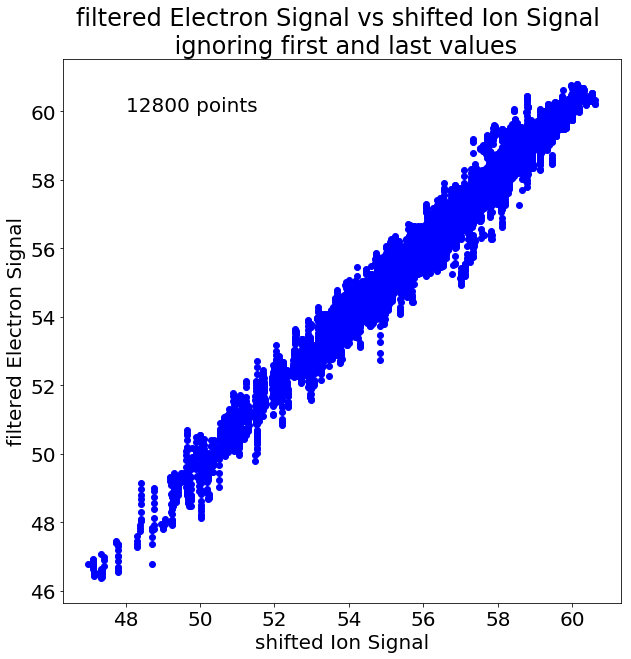

In [16]:
plt.figure(figsize=(10,10))
plt.plot(gmd_ave_bda, filtered_electron_gmd_bda, 'bo')
plt.xlabel('Ion Signal')
plt.ylabel('filtered Electron Signal')
plt.title('filtered Electron Signal vs Ion Signal')
plt.text(48,60,'{} points'.format(len(gmd_ave_bda)))

plt.figure(figsize=(10,10))
plt.plot(shifted_gmd_ave_bda, filtered_electron_gmd_bda, 'bo')
plt.xlabel('shifted Ion Signal')
plt.ylabel('filtered Electron Signal')
plt.title('cut Values at the Start and End of DataSet')
plt.title('filtered Electron Signal vs shifted Ion Signal')
plt.text(48,60,'{} points'.format(len(gmd_ave_bda)))

cut_off = 200

plt.figure(figsize=(10,10))
plt.plot(shifted_gmd_ave_bda[cut_off:-cut_off], filtered_electron_gmd_bda[cut_off:-cut_off], 'bo')
plt.xlabel('shifted Ion Signal')
plt.ylabel('filtered Electron Signal')
plt.title('filtered Electron Signal vs shifted Ion Signal \n ignoring first and last values')
plt.text(48,60,'{} points'.format(len(shifted_gmd_ave_bda[cut_off:-cut_off])))

plt.show()